# Moving Average Optimization

The technical approach to this strategy suggests that when the short-term moving average (STMA) crosses above the long-term moving average (LTMA), it is a signal to buy or go long. Conversely, when the STMA crosses below the LTMA, it is a signal to sell or go short. This approach is based on the principle of momentum, which states that a price moving up or down in period t is likely to continue moving in the same direction in period t+1.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns


In [19]:
# Descargar los datos de cotización de ticker desde yfinance
tick = 'NATIONALUM.NS'
ticker = yf.Ticker(tick)
ticker_history = ticker.history(period='10y')

In [20]:
# # Calculate 10 and 20 day moving averages
ticker_history['ma10'] = ticker_history['Close'].rolling(window=10).mean()
ticker_history['ma20'] = ticker_history['Close'].rolling(window=20).mean()

In [21]:
# Crear una columna con la señal de compra y venta
ticker_history['signal'] = 0.0
ticker_history['signal'] = np.where(ticker_history['ma10'] > ticker_history['ma20'], 1.0, 0.0)

In [22]:

# Calcular los retornos diarios de ticker
ticker_history['returns'] = ticker_history['Close'].pct_change()

In [23]:
# Calcular los retornos de la estrategia
ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

In [24]:
# Calculate cumulative performance of ticker and strategy
ticker_history['cumulative_returns'] = (1 + ticker_history['returns']).cumprod()
ticker_history['cumulative_strategy_returns'] = (1 + ticker_history['strategy_returns']).cumprod()

ticker_history['cumulative_strategy_returns'][-1]

2.1935481173530498



This indicates that the result of the strategy in the analyzed period is 827%. In the same period, a Buy and Hold strategy would have had a return of 810%

We can create a graph with the accumulated returns for the ticker and the strategy applied with Plotly.

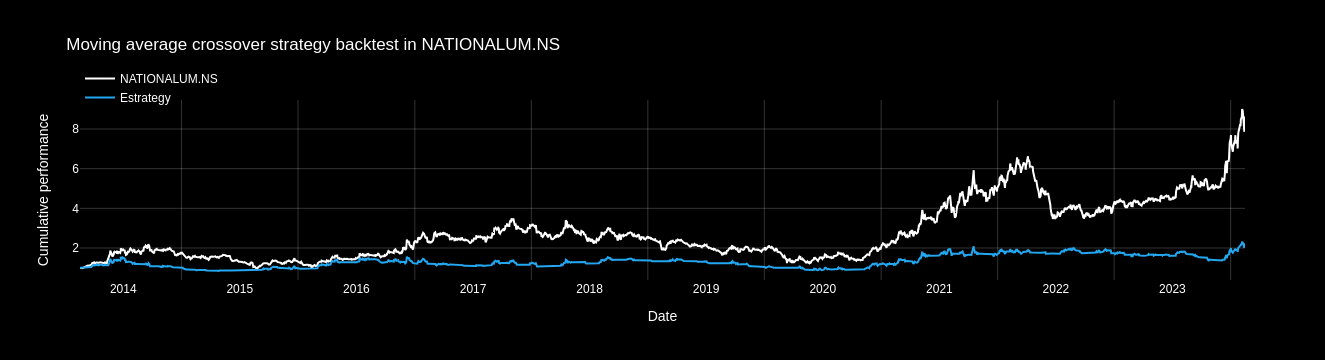

In [25]:
# Create a chart with cumulative ticker and strategy performance
fig = go.Figure()
fig.add_trace(go.Scatter(x=ticker_history.index, y=ticker_history['cumulative_returns'], name=tick,
                         line=dict(color='white', width=2)))
fig.add_trace(go.Scatter(x=ticker_history.index, y=ticker_history['cumulative_strategy_returns'], name='Estrategy',
                         line=dict(color='#22a7f0', width=2)))
fig.update_layout(title=('Moving average crossover strategy backtest in ' + tick),
                  xaxis_title='Date',
                  yaxis_title='Cumulative performance',
                  font=dict(color='white'),
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  legend=dict(x=0, y=1.2, bgcolor='rgba(0,0,0,0)'),
                  yaxis=dict(gridcolor='rgba(255,255,255,0.2)'),
                  xaxis=dict(gridcolor='rgba(255,255,255,0.2)'))
fig.update_xaxes(showgrid=True, ticklabelmode="period")
fig.update_yaxes(showgrid=True)
fig.show()

But performance is not the only important thing, we can also analyze the drawdown of the strategy.

The term Drawdown refers to the maximum loss that an investment portfolio or asset has experienced from its maximum value. It is the difference between the highest point of the investment's value and the lowest point it reaches before recovering.

The Drawdown is important because it provides information about the risk and volatility of an investment. A high Drawdown indicates that an investment is more volatile and risky, while a low one suggests a more stable investment. Therefore, this measure can help investors manage their portfolios and evaluate the potential risk and rewards of their investments.


### We can study the drawdown of the strategy with the following code:

In [26]:
# Calcular el máximo acumulado de los retornos de la estrategia hasta el momento
ticker_history['cumulative_strategy_max'] = ticker_history['cumulative_strategy_returns'].cummax()

# Calcular la caída actual de los retornos de la estrategia en relación con el máximo acumulado
ticker_history['cumulative_strategy_drawdown'] = (ticker_history['cumulative_strategy_returns'] / ticker_history['cumulative_strategy_max']) - 1

# Imprimir el drawdown actual
print('El drawdown actual de la estrategia es:', ticker_history['cumulative_strategy_drawdown'][-1])

El drawdown actual de la estrategia es: -0.05222734254992334


The current drawdown of the strategy is: -0.06893030165577152

But what if we change STMA to 20 and STMA to 40? Or STMA at 9 and STMA at 21? Considering that the most common MAs are 5, 7, 9, 10, 20, 21, 30, 40, 50, 100 and 200, we can analyze the returns and losses of different MAs combined.

### Matrix returns with different Moving Averages

To create the matrix, we first develop a similar MA crossover model


In [27]:
# Definir las medias móviles lenta y rápida
fast_ma = 10
slow_ma = 20

# Calcular las medias móviles de la estrategia
ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

# Crear una columna con la señal de compra y venta
ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

# Calcular los retornos diarios de ticker y de la estrategia
ticker_history['returns'] = ticker_history['Close'].pct_change()
ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

Next, we create a null matrix with different combinations of moving averages using a Pandas DataFrame:


In [28]:
# Crear una matriz de retornos con diferentes combinaciones de medias móviles
fast_ma_range = [5,7,9,10,20,21,30,34,40,44,50,100]
slow_ma_range = [7,9,10,20,21,30,34,40,44,50,100,200]
returns_matrix = pd.DataFrame(index=fast_ma_range, columns=slow_ma_range)
returns_matrix

,7,9,10,20,21,30,34,40,44,50,100,200
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As a result, we obtain a 12x12 null matrix. To fill it with the hypothetical returns of strategies with different MA combinations we use 2 for loops:

In [29]:
for fast_ma in fast_ma_range:
    for slow_ma in slow_ma_range:
        # Calcular las medias móviles de la estrategia
        ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
        ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

        # Crear una columna con la señal de compra y venta
        ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

        # Calcular los retornos diarios de ticker y de la estrategia
        ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

        # Calcular el rendimiento acumulado de la estrategia
        cumulative_strategy_returns = (1 + ticker_history['strategy_returns']).cumprod()

        # Añadir el rendimiento acumulado de la estrategia a la matriz de retornos
        returns_matrix.loc[fast_ma, slow_ma] = cumulative_strategy_returns[-1]

returns_matrix

,7,9,10,20,21,30,34,40,44,50,100,200
5,3.067933,5.775498,5.877287,4.515148,4.380396,3.096984,3.917246,3.608352,3.861782,4.195839,4.154977,6.846116
7,1.0,3.969468,4.121604,4.308234,3.663417,2.957377,3.781273,3.348573,4.542411,6.445931,4.908741,5.875299
9,2.124353,1.0,6.693483,3.258262,3.232371,2.796733,2.177661,2.962003,2.77544,3.596815,4.863514,6.140905
10,2.042826,1.257898,1.0,2.193548,2.71609,2.586647,2.372384,2.634396,2.885144,3.977421,4.492071,6.358819
20,1.789926,2.366729,3.515501,1.0,3.159011,3.372445,2.380262,2.683904,4.520969,3.748247,3.539803,5.407463
21,2.092918,2.372015,2.822893,2.427098,1.0,2.63682,2.603,3.686522,3.846135,3.492581,3.79707,5.456823
30,2.262024,2.391954,2.586227,1.983622,2.537016,1.0,2.602951,4.856294,3.220858,4.754772,3.387643,7.59187
34,1.812195,3.146679,2.888403,2.878844,2.632502,2.632551,1.0,4.619829,3.566276,3.500711,3.32193,7.567225
40,2.020495,2.284188,2.568245,2.52087,1.835273,1.393197,1.464507,1.0,2.326598,2.43762,3.654118,6.295435
44,1.463563,2.395335,2.304254,1.470505,1.728516,2.064079,1.864159,2.857436,1.0,2.329718,4.443491,6.118099


Now we have a complete matrix with returns of strategies with different MA combinations. To visualize we can create a heat map using the Seaborn library:

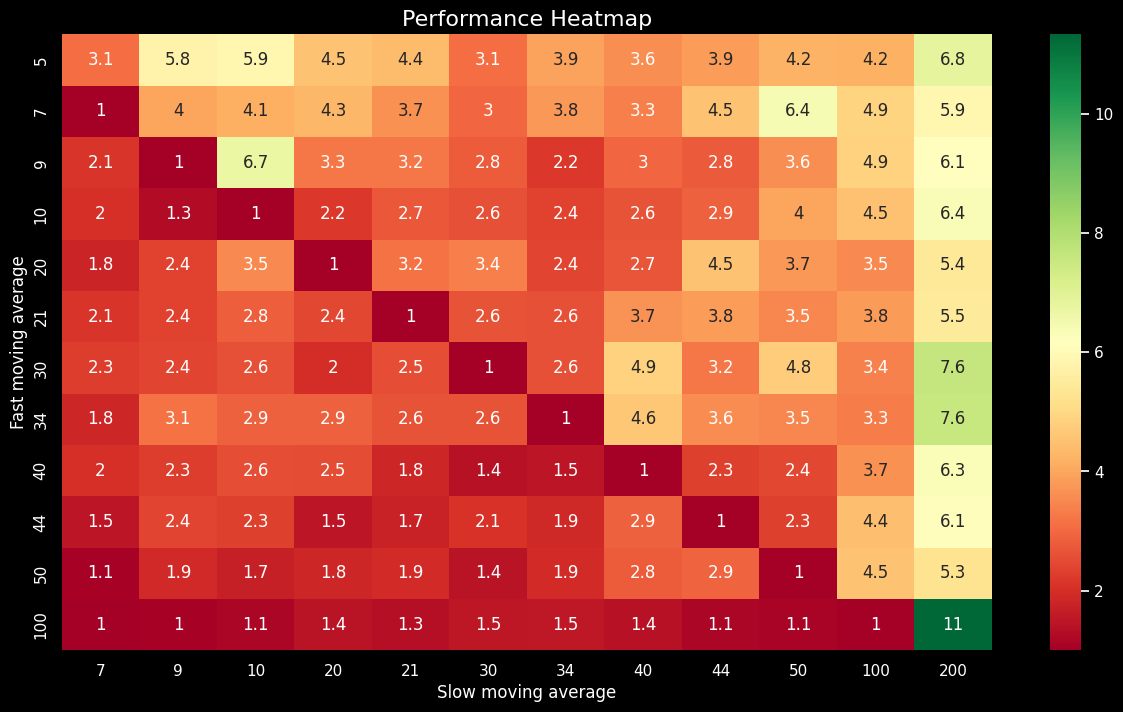

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Haga una copia de return_matrix y convierta el índice y las columnas al tipo de cadena
valores = returns_matrix.copy()
valores.index = valores.index.astype(str)
valores.columns = valores.columns.astype(str)

#valores = returns_matrix.values
valores = valores.astype(float)

# Cambiamos el estilo del gráfico y establecemos el esquema de color predeterminado
plt.style.use('dark_background')
sns.set_palette("bright")

# Cambiamos el tamaño de la fuente a 10 y el color a blanco
sns.set(font_scale=1.0, rc={'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'})

# Cambiamos el color de fondo del gráfico a negro
fig = plt.figure(figsize=(15, 8))
fig.set_facecolor('#000000')

# Crear el heatmap después de configurar el tamaño del gráfico y el estilo
sns.heatmap(valores, annot=True, cmap='RdYlGn')

# Agregamos títulos a los ejes
plt.xlabel('Slow moving average', fontsize=12, color='white')
plt.ylabel('Fast moving average', fontsize=12, color='white')

plt.title('Performance Heatmap', fontsize=16, color='white')

plt.show()


As we can see from the chart above, strategies with different combinations of moving averages can achieve uneven returns. The 2 best combinations for the period analyzed are:

- STMA:30, LTMA:200 with a cumulative return of 16 (451.48%)
- STMA:20, LTMA:200 with a cumulative return of 18 (421.29%)
- STMA 20, LTMA:34 with a cumlative return of 14

200, 50 and 40 seem to be good options to choose as LTMA for this value but it is not very clear to choose a good candidate for STMA.

Additionally, we can analyze the drawdowns for different combinations of moving averages as we did with the returns.

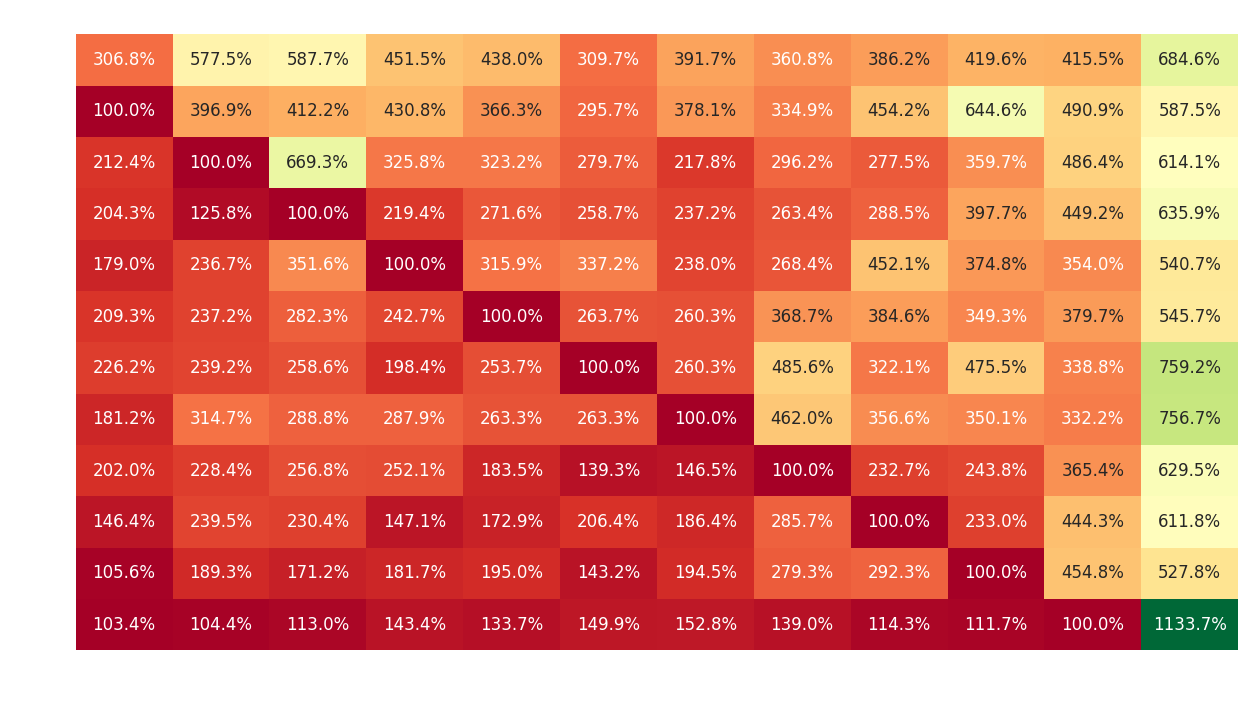

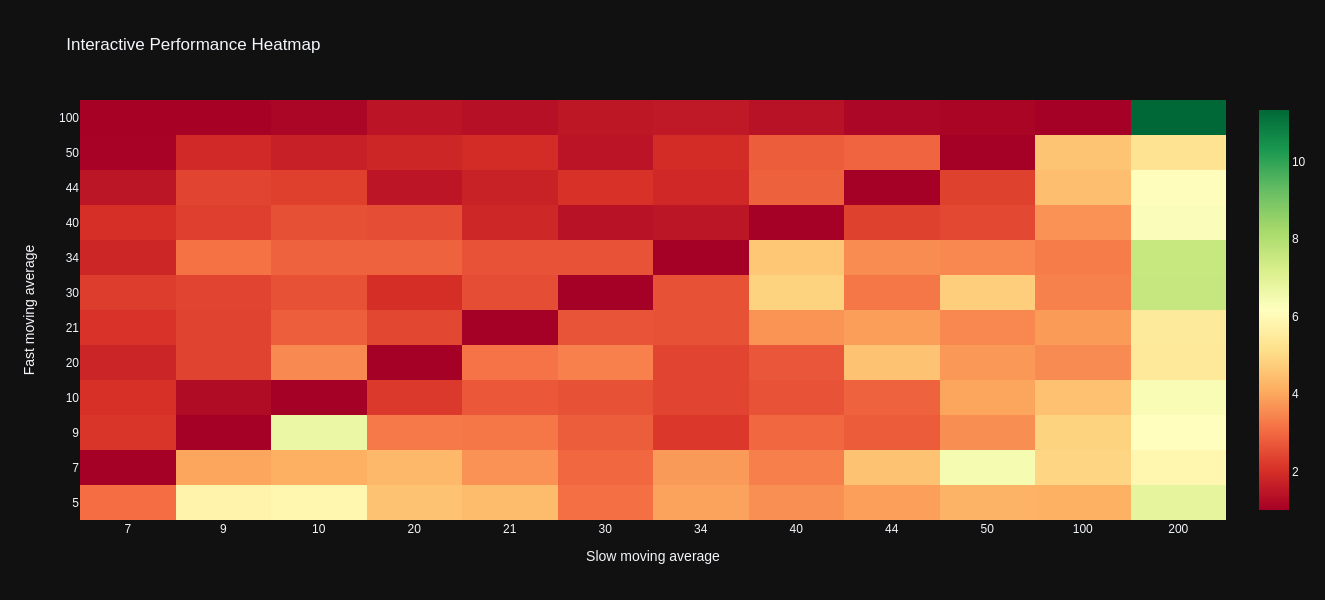

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

# Assuming 'returns_matrix' is a DataFrame with numerical values
valores = returns_matrix.copy()
valores.index = valores.index.astype(str)
valores.columns = valores.columns.astype(str)

# Convert the DataFrame to numeric format
valores = valores.apply(pd.to_numeric, errors='coerce')

# Create a custom hover template with percentage for Plotly
hover_template = 'Fast moving average: %{y}<br>Slow moving average: %{x}<br>Percentage: %{z:.1%}'

# Create a Seaborn heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(valores, annot=True, cmap='RdYlGn', fmt=".1%", cbar=False)

# Manually set tick labels on the axes
plt.xticks(ticks=range(len(valores.columns)), labels=valores.columns, rotation=45)
plt.yticks(ticks=range(len(valores.index)), labels=valores.index, rotation=0)

# Add titles and labels
plt.xlabel('Slow moving average', fontsize=12, color='white')
plt.ylabel('Fast moving average', fontsize=12, color='white')
plt.title('Performance Heatmap', fontsize=16, color='white')

# Show the static Seaborn plot
plt.show()

# Create an interactive Plotly heatmap
fig = go.Figure(data=go.Heatmap(z=valores.values,
                                x=valores.columns,
                                y=valores.index,
                                hovertemplate=hover_template,
                                colorscale='RdYlGn'))

# Update axis labels and layout
fig.update_xaxes(title_text='Slow moving average')
fig.update_yaxes(title_text='Fast moving average')
fig.update_layout(
    title='Interactive Performance Heatmap',
    template='plotly_dark',
    height=600,  # Adjust the height as needed
    width=800    # Adjust the width as needed
)

# Show the interactive Plotly plot
fig.show()


## Drawdown matrix with different moving averages

We create another null matrix with different combinations of moving averages using a Pandas DataFrame:

In [32]:
# Definir las medias móviles lenta y rápida
fast_ma = 10
slow_ma = 20

# Calcular las medias móviles de la estrategia
ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

# Crear una columna con la señal de compra y venta
ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

# Calcular los retornos diarios de ticker y de la estrategia
ticker_history['returns'] = ticker_history['Close'].pct_change()
ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

# Crear una matriz de retornos con diferentes combinaciones de medias móviles
fast_ma_range = [5,7,9,10,20,21,30,34,40,44,50,100]
slow_ma_range = [7,9,10,20,21,30,34,40,44,50,100,200]
dd_matrix = pd.DataFrame(index=fast_ma_range, columns=slow_ma_range)
dd_matrix

,7,9,10,20,21,30,34,40,44,50,100,200
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
for fast_ma in fast_ma_range:
    for slow_ma in slow_ma_range:
        
        # Calcular las medias móviles de la estrategia
        ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
        ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

        # Crear una columna con la señal de compra y venta
        ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

        # Calcular los retornos diarios de ticker y de la estrategia
        ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

        # Calcular el rendimiento acumulado de la estrategia
        ticker_history['cumulative_strategy_returns'] = (1 + ticker_history['strategy_returns']).cumprod()

        # Calcular el máximo acumulado de los retornos de la estrategia hasta el momento
        ticker_history['cumulative_strategy_max'] = ticker_history['cumulative_strategy_returns'].cummax()

        # Calcular la caída actual de los retornos de la estrategia en relación con el máximo acumulado
        ticker_history['cumulative_strategy_drawdown'] = (ticker_history['cumulative_strategy_returns'] / ticker_history['cumulative_strategy_max']) - 1

        # Añadir el drawdown acumulado de la estrategia a la matriz de drawdowns
        dd_matrix.loc[fast_ma, slow_ma] = ticker_history['cumulative_strategy_drawdown'][-1]

dd_matrix

,7,9,10,20,21,30,34,40,44,50,100,200
5,-0.18218,-0.15485,-0.129394,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
7,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
9,-0.150539,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
10,-0.220938,-0.375924,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
20,-0.267754,0.0,0.0,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
21,-0.116419,0.0,-0.023678,-0.081732,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
30,-0.037456,0.0,0.0,-0.101389,-0.139678,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
34,-0.081921,-0.00722,-0.00722,-0.063329,-0.112364,-0.154831,0.0,-0.052227,-0.052227,-0.052227,-0.052227,-0.052227
40,-0.129153,-0.088954,-0.013853,-0.143911,-0.193699,-0.101738,-0.003854,0.0,-0.052227,-0.052227,-0.052227,-0.052227
44,-0.219256,-0.079684,0.0,-0.143001,-0.160022,-0.005049,-0.057735,-0.044156,0.0,-0.109319,-0.052227,-0.052227


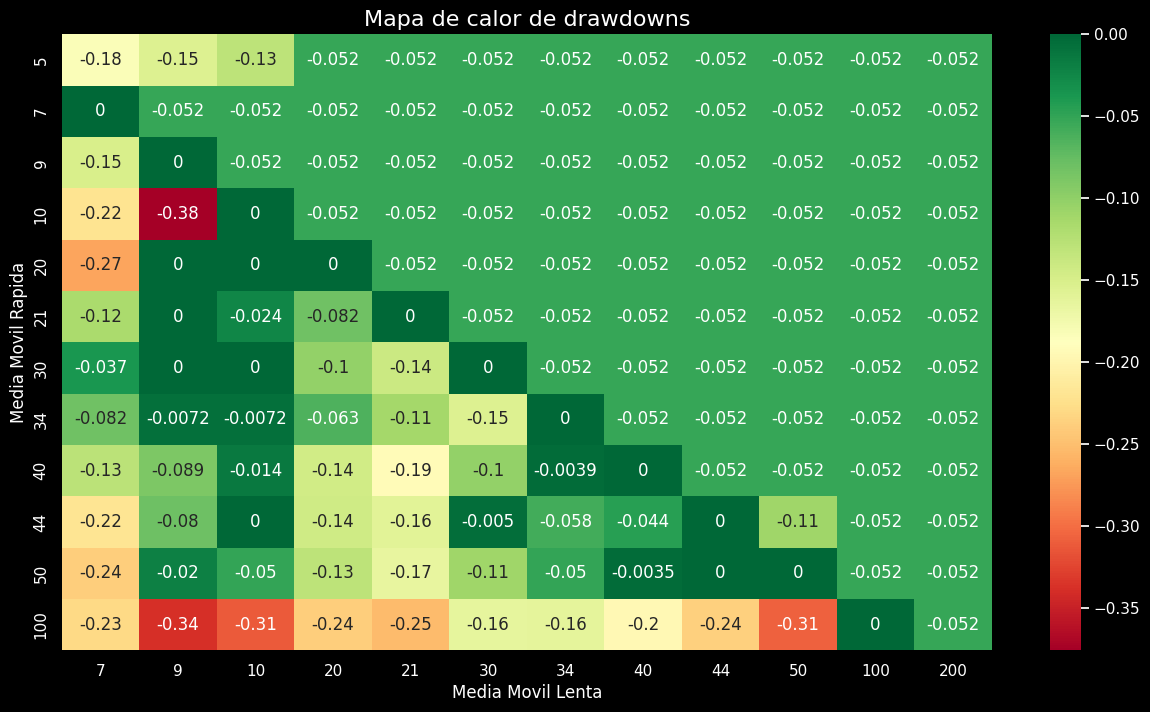

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Haga una copia de return_matrix y convierta el índice y las columnas al tipo de cadena
valores_dd = dd_matrix.copy()
valores_dd.index = valores_dd.index.astype(str)
valores_dd.columns = valores_dd.columns.astype(str)

# Convertir valores a tipo flotante
valores_dd = valores_dd.astype(float)

# Cambiamos el estilo del gráfico y establecemos el esquema de color predeterminado
plt.style.use('dark_background')
sns.set_palette("bright")

# Cambiamos el tamaño de la fuente a 10 y el color a blanco
sns.set(font_scale=1.0, rc={'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'})

# Cambiamos el color de fondo del gráfico a negro
fig = plt.figure(figsize=(15, 8))
fig.set_facecolor('#000000')

# Crear el heatmap después de configurar el tamaño del gráfico y el estilo
sns.heatmap(valores_dd, annot=True, cmap='RdYlGn')

# Agregamos títulos a los ejes
plt.xlabel('Media Movil Lenta', fontsize=12, color='white')
plt.ylabel('Media Movil Rapida', fontsize=12, color='white')

plt.title('Mapa de calor de drawdowns', fontsize=16, color='white')

plt.show()


Again, we see positive metrics in strategies that work with 44 and 34 LTMA for this asset. On the other hand, the matrix presents high reductions for fast numbers such as STMA:9//LTMA:7 or STMA:7//LTMA:9.


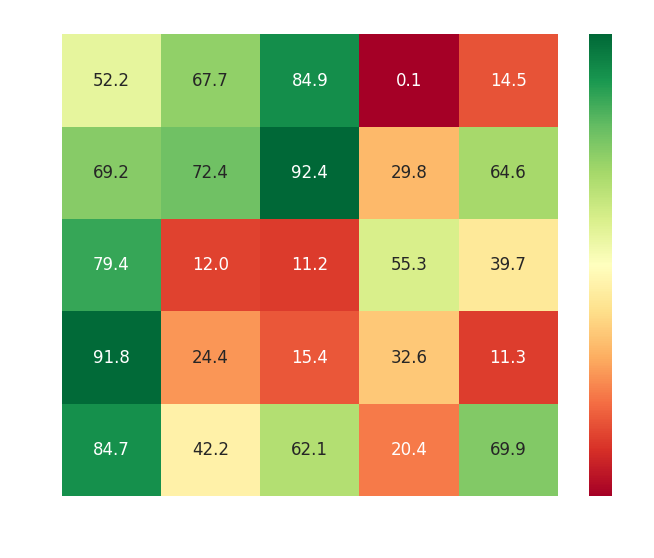

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some example data
data = np.random.rand(5, 5) * 100  # Replace this with your actual data

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, cmap='RdYlGn', fmt='.1f')  # fmt='.1f' displays one decimal place

# Add titles and labels
plt.title('Heatmap with Percentage of Maximum Value', fontsize=16)
plt.xlabel('X-axis Label', fontsize=12)
plt.ylabel('Y-axis Label', fontsize=12)

# Show the plot
plt.show()


# Next Step

Backtest the Moving average
- make paper trading bot that will enter a trade withthe given maximized SMA data and exit accordingly
- let define 50,000 INR 
- enter a trade when Fast MA 21 crosses  slow 34 
- exit when Slow MA 34 crosses fast MA 21